In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
first_row = session.query(Measurement).first()
first_row.__dict__

for row in session.query(Measurement.prcp, Measurement.date).limit(15).all():
    print(row)

(0.08, '2010-01-01')
(0.0, '2010-01-02')
(0.0, '2010-01-03')
(0.0, '2010-01-04')
(None, '2010-01-06')
(0.06, '2010-01-07')
(0.0, '2010-01-08')
(0.0, '2010-01-09')
(0.0, '2010-01-10')
(0.01, '2010-01-11')
(0.0, '2010-01-12')
(0.0, '2010-01-14')
(0.0, '2010-01-15')
(0.0, '2010-01-16')
(0.0, '2010-01-17')


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date))
# max_date = engine.execute('SELECT MAX(date) maximum FROM measurement').fetchone()

print (max_date[0])

f = '%Y-%m-%d'
max_date = dt.datetime.strptime(max_date[0][0], f)
one_year = dt.timedelta(days=365)
one_year_ago = max_date - one_year

print (one_year_ago.strftime(f))

('2017-08-23',)
2016-08-23


,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


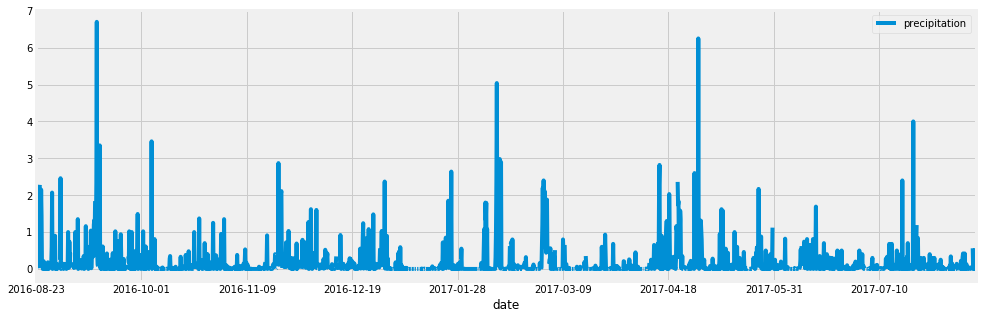

In [14]:
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date

#query = 'SELECT date,prcp FROM measurement WHERE date BETWEEN \''+one_year_ago.strftime(f)+'\' AND \''+max_date.strftime(f)+'\''+' ORDER BY date'
#last_12_months = engine.execute(query)

qry = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= one_year_ago.strftime(f)).filter(Measurement.date <= max_date.strftime(f)).order_by(Measurement.date)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(qry,columns=['date','precipitation'])
df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', figsize = (15,5))

df.head()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
#stations = engine.execute('SELECT COUNT(station) FROM station').fetchone()
#print (stations[0])

print (session.query(func.count(Station.station)).all()[0][0])

session.query(Station.station).all()

9


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#activestations = engine.execute('SELECT station,COUNT(station) FROM measurement GROUP BY station ORDER BY COUNT(station) DESC')

#for row in activestations:
#    print (row)
    
activestations2 = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

print (activestations2)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
print (most_active.station)

#temps = engine.execute('SELECT MIN(tobs), MAX(tobs), AVG(tobs) from measurement WHERE station=\''+most_active.station+'\'')
#print (temps.first())

temps2 = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active.station).first()

print (temps2)

USC00519281
(54.0, 85.0, 71.66378066378067)


USC00519281


,temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


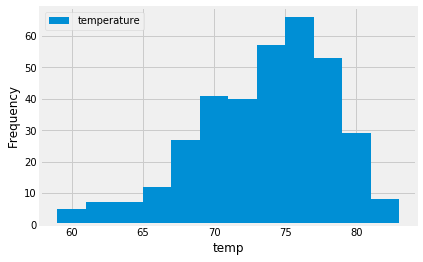

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#station_temp = engine.execute('SELECT COUNT(tobs),station from measurement GROUP BY station ORDER BY COUNT(tobs) DESC').fetchone()
#print (station_temp.station)

station_temp2 = session.query(func.count(Measurement.tobs),Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print (station_temp2.station)

#query = 'SELECT tobs FROM measurement WHERE date BETWEEN \''+one_year_ago.strftime(f)+'\' AND \''+max_date.strftime(f)+'\''+' AND station='+'\''+station_temp.station+'\''+' ORDER BY date'
#station_temps = engine.execute(query)

station_temps2 = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago.strftime(f)).\
filter(Measurement.date <= max_date.strftime(f)).\
filter(Measurement.station == station_temp2.station).order_by(Measurement.date)

df = pd.DataFrame(station_temps2,columns=['temperature'])

#hist = df.hist()

plot = df.plot(kind="hist",bins=12)
plot.set_xlabel("temp")
plot.set_ylabel("Frequency")

df.head()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps(one_year_ago.strftime(f),max_date.strftime(f))
print (temps)

[(58.0, 74.59058295964125, 87.0)]


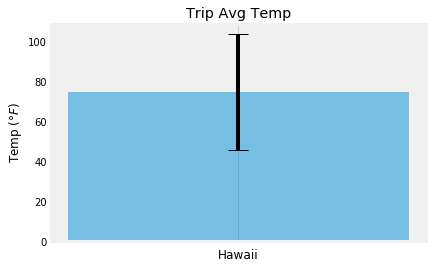

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg = temps[0][1]
error = temps[0][2] - temps[0][0]

fig, ax = plt.subplots()
ax.bar("", avg, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel("Hawaii")
ax.set_ylabel('Temp ($\degree F$)')
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(False)


# Save the figure and show
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

x = session.query(Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation)\
.filter(Measurement.date >= one_year_ago.strftime(f))\
.filter(Measurement.date <= max_date.strftime(f))\
.filter(Measurement.station == Station.station)\
.group_by(Measurement.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()


#new_query = 'SELECT measurement.station,SUM(prcp), station.name, station.latitude,station.longitude, station.elevation FROM measurement,station'
#new_query += ' WHERE date BETWEEN \''+one_year_ago.strftime(f)+'\' AND \''+max_date.strftime(f)+'\''
#new_query += ' AND measurement.station = station.station GROUP BY measurement.station ORDER BY SUM(prcp) DESC'

#print (new_query,'\n')
#big_rains = engine.execute(new_query)


for row in x:
    print (row)

('USC00516128', 147.81000000000006, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 70.03000000000003, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 48.510000000000026, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 38.01, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 33.239999999999995, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519397', 16.089999999999986, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', 4.59, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
startDate = "2019-04-08"
endDate = "2019-04-19"

# Set the start and end date of the trip
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

# Use the start and end date to create a range of dates
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

# Loop through the list of %m-%d strings and calculate the normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)],
 [(61.0, 71.79310344827586, 79.0)],
 [(62.0, 71.55357142857143, 81.0)],
 [(65.0, 71.93103448275862, 77.0)],
 [(67.0, 72.49152542372882, 77.0)],
 [(65.0, 72.42105263157895, 83.0)]]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)

#add date column
normalsTable["Date"] = dateList

#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable

,Low Temp,Avg Temp,High Temp
Date,,,
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0


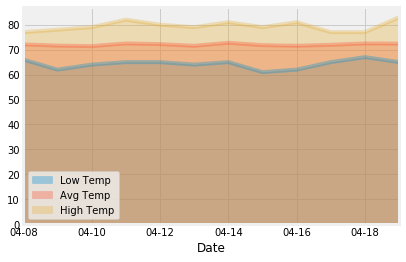

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.333)